# FordA Novelty Detection with Counterfactual Explanations

3 layer explainable AI pipeline for time series novelty detection:

1. **Detection Layer** - Compare novelty detection methods (CNN-AE, IF, OCSVM, LOF)
2. **Counterfactual Layer** - Uses nearest neighbour approach to generate counterfactual explanations
3. **LLM Quality Filter** - LLM (OpenAI) to evaluate counterfactual explanations

## Dataset
FordA - Industrial engine sensor measurements from UCR Archive:
- 4,921 total samples (3,601 train + 1,320 test)
- 500 timesteps per sample
- 2 classes: Normal operation (-1) vs Faulty (1)

## Novelty Detection Approach
The detectors are trained ONLY on normal samples (semi-supervised novelty detection). Learn the distribution of normal (Class -1) and flag deviations from it as novel/anomalous.

---
## 1. Setup & Configuration

In [116]:
%pip install numpy pandas scipy scikit-learn matplotlib seaborn openai tqdm torch --quiet

import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import time
import os
import json
from scipy import signal
from scipy.stats import skew, kurtosis, ttest_ind
from scipy.spatial.distance import cdist, euclidean
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Literal
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from tqdm import tqdm
from openai import OpenAI

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("Dependencies loaded successfully")

Python(88887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dependencies loaded successfully


In [117]:
@dataclass
class PipelineConfig:    
    # Dataset
    dataset: str = 'forda'
    data_dir: str = './data/FordA'
    signal_length: int = 500
    n_channels: int = 1
    normal_class: int = -1  
    
    # Detection 
    contamination: float = 0.1
    
    # Isolation Forest
    if_n_estimators: int = 100
    if_max_samples: str = 'auto'
    if_max_features: float = 1.0
    
    # One-Class SVM
    svm_kernel: str = 'rbf'
    svm_nu: float = 0.1
    svm_gamma: str = 'scale'
    
    # Local Outlier Factor
    lof_n_neighbors: int = 20
    
    # CNN Autoencoder
    cnn_epochs: int = 30
    cnn_batch_size: int = 64
    cnn_lr: float = 1e-3
    cnn_weight_decay: float = 1e-4
    cnn_reconstruction_percentile: float = 95.0
    
    # Counterfactual
    n_neighbors: int = 5
    distance_metric: str = 'euclidean'
    cf_search_k: int = 50
    
    # LLM
    llm_model: str = 'gpt-4o-mini'
    llm_temperature: float = 0.2
    llm_max_tokens: int = 512
    llm_api_key_env: str = 'OPENAI_API_KEY'
    
    # Primary detector for counterfactual generation
    primary_detector: str = 'isolation_forest'

    def __repr__(self) -> str:
        return (
            f"PipelineConfig(\n"
            f"  dataset='{self.dataset}',\n"
            f"  signal_length={self.signal_length},\n"
            f"  n_channels={self.n_channels},\n"
            f"  data_dir='{self.data_dir}'\n"
            f")"
        )
    
config = PipelineConfig()
print(f"Pipeline configured with: {config}")

Pipeline configured with: PipelineConfig(
  dataset='forda',
  signal_length=500,
  n_channels=1,
  data_dir='./data/FordA'
)


---
## 2. Data Loading

In [118]:
class FordADataLoader:        
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.data_dir = Path(config.data_dir)

    
    def _load_ucr_file(self, filepath: Path) -> Tuple[np.ndarray, np.ndarray]:
        data = np.loadtxt(filepath)
        labels = data[:, 0].astype(int)
        signals = data[:, 1:]
        return signals, labels
    
    def load(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        X_train_raw, y_train_raw = self._load_ucr_file(self.data_dir / "FordA_TRAIN.txt")
        X_test_raw, y_test_raw = self._load_ucr_file(self.data_dir / "FordA_TEST.txt")
        
        # summary stats
        all_labels = np.concatenate([y_train_raw, y_test_raw])
        total_normal = np.sum(all_labels == self.config.normal_class)
        total_anomaly = np.sum(all_labels != self.config.normal_class)

        print(f"\nDataset summary:")
        print(f"  Total records: {len(all_labels)}")
        print(f"  Normal (Class {self.config.normal_class}): {total_normal}")
        print(f"  Novel (Other classes): {total_anomaly}")

        print(f"\nSplit:")
        print(f"  Train: {len(X_train_raw)} | Test: {len(X_test_raw)}")

        y_train = (y_train_raw != self.config.normal_class).astype(int)
        y_test = (y_test_raw != self.config.normal_class).astype(int)
        
        X_train = X_train_raw[:, :, np.newaxis]
        X_test = X_test_raw[:, :, np.newaxis]
        
        print(f"\nData loaded: Train {X_train.shape}, Test {X_test.shape}")
        print(f"  Train - Normal: {np.sum(y_train==0)}, Novel: {np.sum(y_train==1)}")
        print(f"  Test  - Normal: {np.sum(y_test==0)}, Novel: {np.sum(y_test==1)}")
    
        return X_train, X_test, y_train, y_test

In [119]:
# Load data
data_loader = FordADataLoader(config)
X_train, X_test, y_train, y_test = data_loader.load()


Dataset summary:
  Total records: 4921
  Normal (Class -1): 2527
  Novel (Other classes): 2394

Split:
  Train: 3601 | Test: 1320

Data loaded: Train (3601, 500, 1), Test (1320, 500, 1)
  Train - Normal: 1846, Novel: 1755
  Test  - Normal: 681, Novel: 639


---
## 3. Preprocessing
UCR archive data comes prenormalised, doesn't have NANs and comes ready to use. This contrasts with PTB-XL where bandpass filtering and normalisation were necessary.

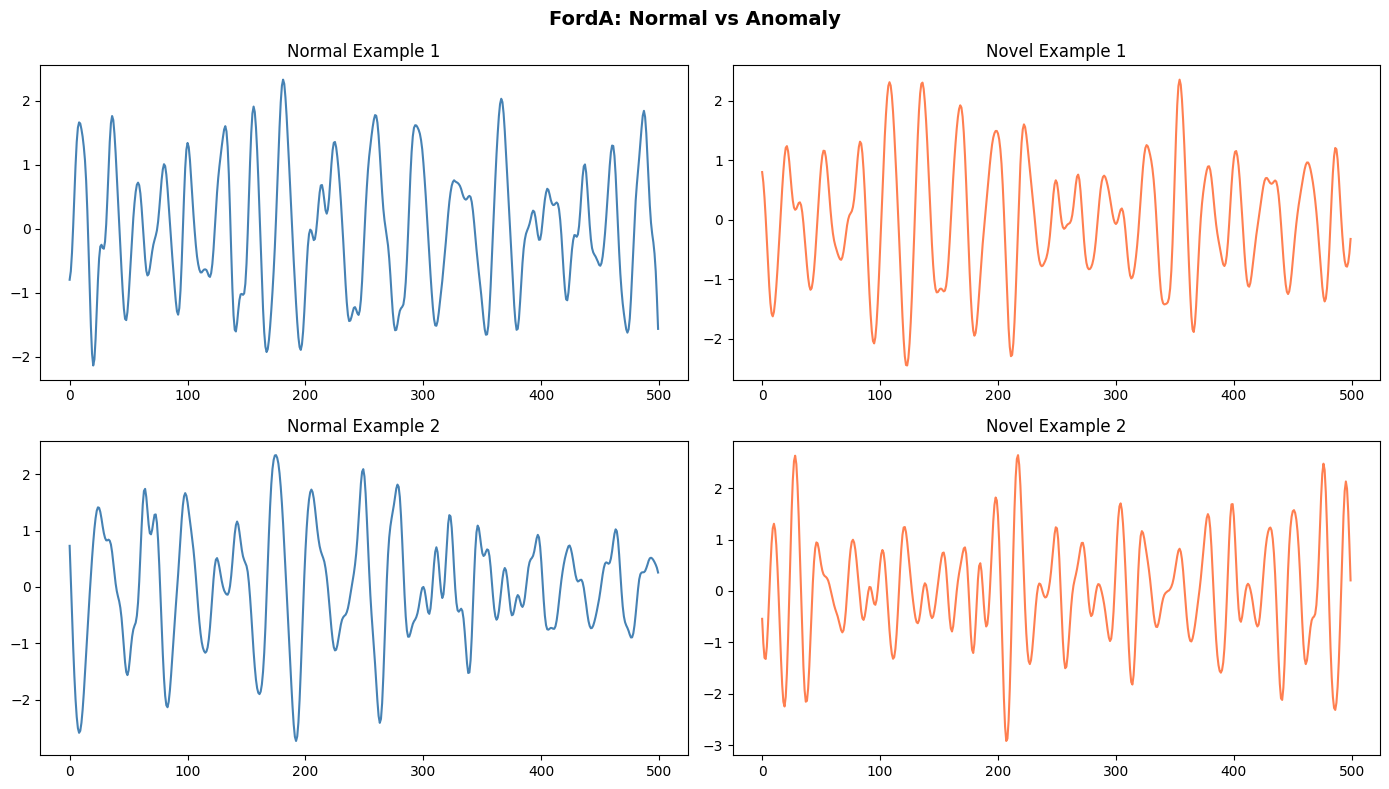

In [120]:
# Visualize sample sensor readings
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Find examples
normal_idx = np.where(y_train == 0)[0][:2]
anomaly_idx = np.where(y_train == 1)[0][:2]

for i, idx in enumerate(normal_idx):
    axes[i, 0].plot(X_train[idx, :, 0], color='steelblue')
    axes[i, 0].set_title(f'Normal Example {i+1}')
    
for i, idx in enumerate(anomaly_idx):
    axes[i, 1].plot(X_train[idx, :, 0], color='coral')
    axes[i, 1].set_title(f'Novel Example {i+1}')

plt.suptitle('FordA: Normal vs Anomaly', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Feature Extraction

In [121]:
class TimeSeriesFeatureExtractor:
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.n_channels = config.n_channels
        self.feature_names = []
        self._build_feature_names()
    
    def _build_feature_names(self):
        self.feature_names = [
            # statistical
            'mean', 'std', 'var', 'min', 'max', 'range', 'median',
            'skewness', 'kurtosis', 'rms', 'zero_crossings',
            
            # temporal/peaks
            'n_peaks', 'peak_interval_mean', 'peak_interval_std', 'peak_interval_range',
            'peak_height_mean', 'peak_height_std', 'peak_regularity',
            
            # frequency
            'total_power', 'low_freq_power', 'mid_freq_power', 'high_freq_power',
            'dominant_freq', 'spectral_entropy', 'spectral_centroid', 'bandwidth',
            
            # autocorrelation
            'autocorr_lag1', 'autocorr_lag5', 'autocorr_lag10', 'trend_slope'
        ]
    
    def _extract_statistical(self, x: np.ndarray) -> Dict[str, float]:
        return {
            'mean': float(np.mean(x)),
            'std': float(np.std(x)),
            'var': float(np.var(x)),
            'min': float(np.min(x)),
            'max': float(np.max(x)),
            'range': float(np.ptp(x)),
            'median': float(np.median(x)),
            'skewness': float(skew(x)),
            'kurtosis': float(kurtosis(x)),
            'rms': float(np.sqrt(np.mean(x**2))),
            'zero_crossings': float(np.sum(np.diff(np.signbit(x))))
        }
    
    def _extract_temporal(self, x: np.ndarray) -> Dict[str, float]:
        threshold = np.mean(x) + 0.5 * np.std(x)
        min_distance = max(1, len(x) // 50)
        
        try:
            peaks, _ = signal.find_peaks(x, height=threshold, distance=min_distance)
        except:
            peaks = np.array([])
        
        features = {'n_peaks': float(len(peaks))}
        
        if len(peaks) > 1:
            intervals = np.diff(peaks)
            features['peak_interval_mean'] = float(np.mean(intervals))
            features['peak_interval_std'] = float(np.std(intervals))
            features['peak_interval_range'] = float(np.ptp(intervals))
            features['peak_regularity'] = float(np.std(intervals) / (np.mean(intervals) + 1e-8))
        else:
            features['peak_interval_mean'] = 0.0
            features['peak_interval_std'] = 0.0
            features['peak_interval_range'] = 0.0
            features['peak_regularity'] = 0.0
        
        if len(peaks) > 0:
            peak_heights = x[peaks]
            features['peak_height_mean'] = float(np.mean(peak_heights))
            features['peak_height_std'] = float(np.std(peak_heights)) if len(peaks) > 1 else 0.0
        else:
            features['peak_height_mean'] = 0.0
            features['peak_height_std'] = 0.0
        
        return features
    
    def _extract_frequency(self, x: np.ndarray) -> Dict[str, float]:
        try:
            fft_vals = np.abs(np.fft.rfft(x))
            fft_freq = np.fft.rfftfreq(len(x))  # No sampling rate, normalised frequency
            
            total_power = np.sum(fft_vals**2) + 1e-8
            
            n_bins = len(fft_freq)
            low_mask = np.arange(n_bins) < n_bins // 3
            mid_mask = (np.arange(n_bins) >= n_bins // 3) & (np.arange(n_bins) < 2 * n_bins // 3)
            high_mask = np.arange(n_bins) >= 2 * n_bins // 3
            
            low_power = np.sum(fft_vals[low_mask]**2) / total_power
            mid_power = np.sum(fft_vals[mid_mask]**2) / total_power
            high_power = np.sum(fft_vals[high_mask]**2) / total_power
            
            psd_norm = fft_vals / (np.sum(fft_vals) + 1e-8)
            spectral_entropy = -np.sum(psd_norm * np.log(psd_norm + 1e-8))
            spectral_centroid = np.sum(fft_freq * fft_vals) / (np.sum(fft_vals) + 1e-8)
            bandwidth = np.sqrt(np.sum(((fft_freq - spectral_centroid)**2) * fft_vals) / (np.sum(fft_vals) + 1e-8))
            
            return {
                'total_power': float(total_power),
                'low_freq_power': float(low_power),
                'mid_freq_power': float(mid_power),
                'high_freq_power': float(high_power),
                'dominant_freq': float(fft_freq[np.argmax(fft_vals)]) if len(fft_vals) > 0 else 0.0,
                'spectral_entropy': float(spectral_entropy),
                'spectral_centroid': float(spectral_centroid),
                'bandwidth': float(bandwidth)
            }
        except:
            return {
                'total_power': 0.0, 'low_freq_power': 0.0, 'mid_freq_power': 0.0,
                'high_freq_power': 0.0, 'dominant_freq': 0.0, 'spectral_entropy': 0.0,
                'spectral_centroid': 0.0, 'bandwidth': 0.0
            }
        
    def _extract_autocorr(self, x: np.ndarray) -> Dict[str, float]:
        try:
            autocorr = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
            autocorr = autocorr[len(autocorr)//2:] / (autocorr[len(autocorr)//2] + 1e-10)
            
            return {
                'autocorr_lag1': float(autocorr[1]) if len(autocorr) > 1 else 0.0,
                'autocorr_lag5': float(autocorr[5]) if len(autocorr) > 5 else 0.0,
                'autocorr_lag10': float(autocorr[10]) if len(autocorr) > 10 else 0.0,
                'trend_slope': float(np.polyfit(np.arange(len(x)), x, 1)[0])
            }
        except:
            return {
                'autocorr_lag1': 0.0, 'autocorr_lag5': 0.0,
                'autocorr_lag10': 0.0, 'trend_slope': 0.0
            }
        
    
    def extract_single(self, signal_data: np.ndarray) -> np.ndarray:
        sig = signal_data[:, 0] if signal_data.ndim > 1 else signal_data
        
        features = {}
        features.update(self._extract_statistical(sig))
        features.update(self._extract_temporal(sig))
        features.update(self._extract_frequency(sig))
        features.update(self._extract_autocorr(sig))
        
        return np.array([features[name] for name in self.feature_names])
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        features = []
        for i in tqdm(range(len(X)), desc="Extracting features"):
            features.append(self.extract_single(X[i]))
        return np.array(features)

In [122]:
# Extract features
feature_extractor = TimeSeriesFeatureExtractor(config)

print(f"Extracting {len(feature_extractor.feature_names)} features per sample...")
X_train_features = feature_extractor.transform(X_train)
X_test_features = feature_extractor.transform(X_test)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

print(f"\n✓ Features extracted: {X_train_scaled.shape[1]} features")

Extracting 30 features per sample...


Extracting features: 100%|██████████| 1320/1320 [00:01<00:00, 857.52it/s] 


✓ Features extracted: 30 features


In [123]:
# find the most discriminative features 
feature_scores = []
for i, feat_name in enumerate(feature_extractor.feature_names):
    normal_vals = X_train_features[y_train == 0, i]
    anomaly_vals = X_train_features[y_train == 1, i]
    
    # Effect size (Cohen's d)
    mean_diff = abs(np.mean(anomaly_vals) - np.mean(normal_vals))
    pooled_std = np.sqrt((np.std(normal_vals)**2 + np.std(anomaly_vals)**2) / 2)
    effect_size = mean_diff / (pooled_std + 1e-10)
    
    feature_scores.append((feat_name, effect_size))

# Sort by effect size and get top 6
feature_scores.sort(key=lambda x: x[1], reverse=True)
key_features = [f[0] for f in feature_scores[:6]]

print("Top 6 most discriminative features:")
for name, score in feature_scores[:6]:
    print(f"  {name}: effect_size={score:.3f}")

Top 6 most discriminative features:
  autocorr_lag10: effect_size=1.030
  autocorr_lag1: effect_size=0.556
  zero_crossings: effect_size=0.529
  n_peaks: effect_size=0.329
  autocorr_lag5: effect_size=0.269
  spectral_entropy: effect_size=0.265


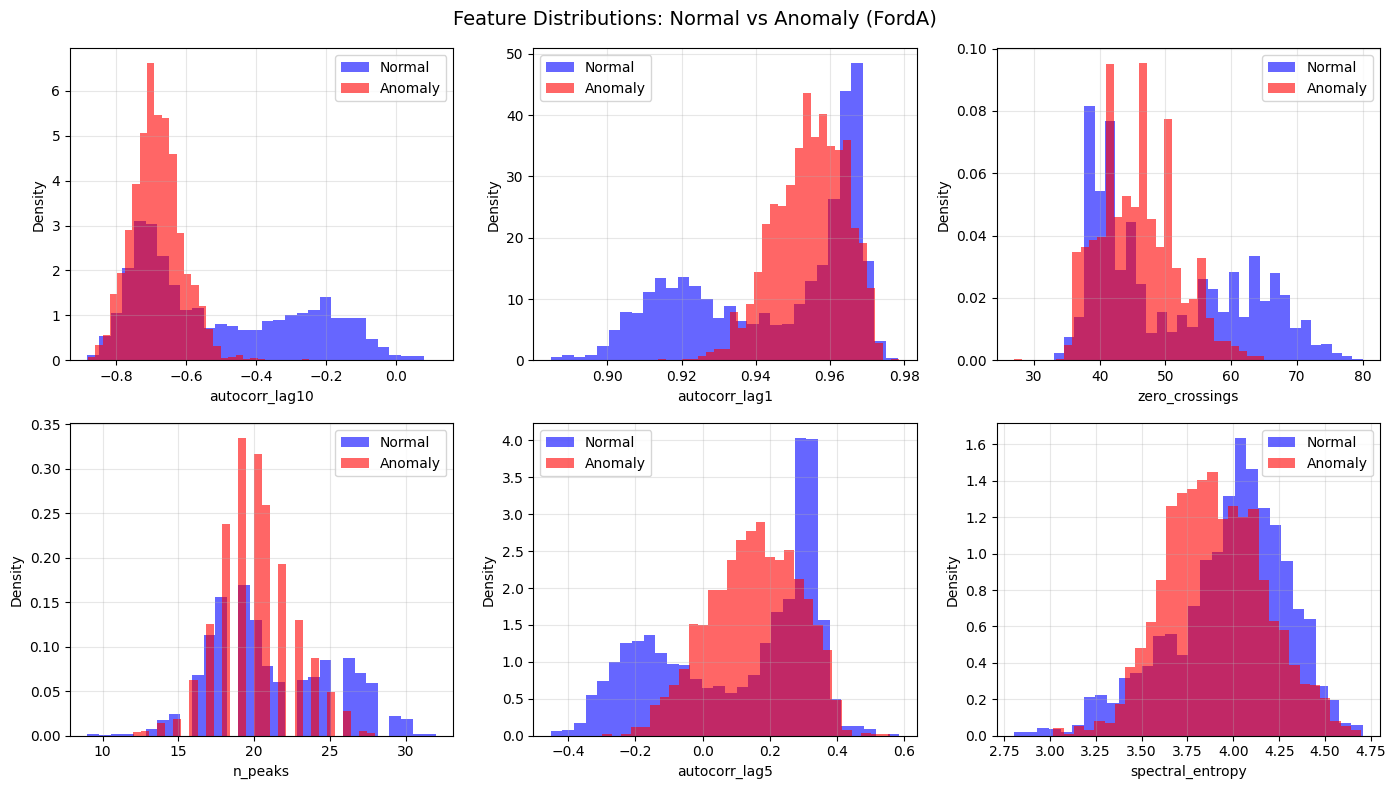

In [124]:
# Visualize Feature Distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, feat_name in zip(axes.flat, key_features):
    if feat_name in feature_extractor.feature_names:
        feat_idx = feature_extractor.feature_names.index(feat_name)
        
        normal_vals = X_train_features[y_train == 0, feat_idx]
        anomaly_vals = X_train_features[y_train == 1, feat_idx]
        
        ax.hist(normal_vals, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
        ax.hist(anomaly_vals, bins=30, alpha=0.6, label='Anomaly', color='red', density=True)
        ax.set_xlabel(feat_name)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions: Normal vs Anomaly (FordA)', fontsize=14)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Detection Layer

Compare 4 novelty detection methods:
- **CNN Autoencoder**: Deep learning, reconstruction error
- **Isolation Forest**: Tree-based isolation
- **One-Class SVM**: Kernel-based boundary
- **Local Outlier Factor**: Density-based

In [125]:
class AnomalyDetector(ABC):
    @abstractmethod
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'AnomalyDetector':
        pass
    
    @abstractmethod
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass
    
    @abstractmethod
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        pass

In [126]:
class IsolationForestDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = IsolationForest(
            n_estimators=config.if_n_estimators,
            max_samples=config.if_max_samples,
            contamination='auto',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        self.threshold = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'IsolationForestDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"  Isolation Forest: Training on {len(X_normal)} normal samples")
        self.model.fit(X_normal)
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, self.config.contamination * 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [127]:
class OCSVMDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = OneClassSVM(
            kernel=config.svm_kernel,
            nu=config.svm_nu,
            gamma=config.svm_gamma
        )
        self.threshold = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'OCSVMDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"  One-Class SVM: Training on {len(X_normal)} normal samples")
        self.model.fit(X_normal)
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, self.config.contamination * 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [128]:
class LOFDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        self.model = LocalOutlierFactor(
            n_neighbors=config.lof_n_neighbors,
            contamination='auto',
            novelty=True,
            n_jobs=-1
        )
        self.threshold = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'LOFDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"  Local Outlier Factor: Training on {len(X_normal)} normal samples")
        self.model.fit(X_normal)
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, self.config.contamination * 100)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return -self.model.decision_function(X)

In [129]:
class ZScoreDetector:  
    def __init__(self, config, aggregation: str = 'max'):
        self.config = config
        self.aggregation = aggregation
        
        self.mean_ = None       
        self.std_ = None       
        self.threshold = None   
        
        self.n_features_ = None
        self.n_train_normal_ = None
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'ZScoreDetector':
        X_normal = X[y == 0] if y is not None else X
        
        self.n_train_normal_ = len(X_normal)
        self.n_features_ = X_normal.shape[1]
        
        self.mean_ = np.mean(X_normal, axis=0)
        self.std_ = np.std(X_normal, axis=0)
        
        self.std_[self.std_ < 1e-10] = 1.0
        
        print(f"  Z-Score Baseline: Training on {self.n_train_normal_} normal samples, "
              f"{self.n_features_} features, aggregation='{self.aggregation}'")
        
        normal_scores = self.decision_function(X_normal)
        self.threshold = np.percentile(normal_scores, (1 - self.config.contamination) * 100)
        
        print(f"  Z-Score Baseline: Threshold set at {self.threshold:.4f} "
              f"({self.config.contamination*100:.0f}% contamination)")
        
        return self
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        z_scores = np.abs((X - self.mean_) / self.std_)
        
        if self.aggregation == 'max':
            scores = np.max(z_scores, axis=1)
        elif self.aggregation == 'mean':
            scores = np.mean(z_scores, axis=1)
        else:
            raise ValueError(f"Unknown aggregation: {self.aggregation}. Use 'max' or 'mean'.")
        
        return scores
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def get_feature_zscores(self, X: np.ndarray) -> np.ndarray:
        return np.abs((X - self.mean_) / self.std_)

In [130]:
# CNN Autoencoder 
class TimeSeriesDataset(Dataset):
    def __init__(self, signals: np.ndarray):
        X = np.array(signals, dtype=np.float32)
        X = np.transpose(X, (0, 2, 1))  
        self.X = torch.tensor(X, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.X[idx]


class TimeSeries1DAutoEncoder(nn.Module):
    def __init__(self, n_channels: int = 1, signal_length: int = 500):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, n_channels, kernel_size=7, stride=2, padding=3, output_padding=1),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Match input size
        if decoded.shape[2] != x.shape[2]:
            decoded = torch.nn.functional.interpolate(decoded, size=x.shape[2], mode='linear', align_corners=False)
        return decoded


class CNNAutoencoderDetector(AnomalyDetector):
    def __init__(self, config: PipelineConfig):
        self.config = config
        # TODO change to mps
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = TimeSeries1DAutoEncoder(config.n_channels, config.signal_length).to(self.device)
        self.threshold = 0.0
        self.training_losses = []
        self.validation_losses = []
        self.normal_mean_error = 0.0
        self.normal_std_error = 0.0
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'CNNAutoencoderDetector':
        X_normal = X[y == 0] if y is not None else X
        print(f"  CNN Autoencoder: Training on {len(X_normal)} normal samples")

        # Split into train/val
        from sklearn.model_selection import train_test_split
        X_train_split, X_val_split = train_test_split(
            X_normal, test_size=0.15, random_state=RANDOM_STATE
        )

        train_dataset = TimeSeriesDataset(X_train_split)
        val_dataset = TimeSeriesDataset(X_val_split)
        train_loader = DataLoader(train_dataset, batch_size=self.config.cnn_batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config.cnn_batch_size, shuffle=False)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.cnn_lr,
                                     weight_decay=self.config.cnn_weight_decay)
        criterion = nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        
        best_val_loss = float('inf')
        best_state = None
        
        for epoch in range(self.config.cnn_epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            for batch_x, _ in train_loader:
                batch_x = batch_x.to(self.device)
                optimizer.zero_grad()
                output = self.model(batch_x)
                loss = criterion(output, batch_x)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * batch_x.size(0)
            
            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    batch_x = batch_x.to(self.device)
                    output = self.model(batch_x)
                    loss = criterion(output, batch_x)
                    val_loss += loss.item() * batch_x.size(0)
            
            train_loss /= len(train_dataset)
            val_loss /= len(val_dataset)
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            
            scheduler.step(val_loss)
            

            print(f"    Epoch {epoch+1}/{self.config.cnn_epochs} - train_loss={train_loss:.6f} val_loss={val_loss:.6f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
        
        # Load best model
        if best_state is not None:
            self.model.load_state_dict(best_state)
        
        # Calculate reconstruction errors on normal training data
        normal_errors = self.decision_function(X_normal)
        self.normal_mean_error = np.mean(normal_errors)
        self.normal_std_error = np.std(normal_errors)
        
        # Set threshold
        self.threshold = np.percentile(normal_errors, self.config.cnn_reconstruction_percentile)
        
        print(f"\n    Reconstruction Error Statistics (Normal Data):")
        print(f"      Mean: {self.normal_mean_error:.6f}")
        print(f"      Std:  {self.normal_std_error:.6f}")
        print(f"      Min:  {np.min(normal_errors):.6f}")
        print(f"      Max:  {np.max(normal_errors):.6f}")
        print(f"    Threshold set at {self.config.cnn_reconstruction_percentile}th percentile: {self.threshold:.6f}")
        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return (self.decision_function(X) >= self.threshold).astype(int)
    
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        self.model.eval()
        dataset = TimeSeriesDataset(X)
        loader = DataLoader(dataset, batch_size=self.config.cnn_batch_size, shuffle=False)
        
        errors = []
        with torch.no_grad():
            for batch_x, _ in loader:
                batch_x = batch_x.to(self.device)
                output = self.model(batch_x)
                mse = torch.mean((output - batch_x) ** 2, dim=(1, 2))
                errors.extend(mse.cpu().numpy())
        
        return np.array(errors)

In [131]:
def evaluate_detector(detector: AnomalyDetector, X: np.ndarray, y: np.ndarray, name: str) -> Dict[str, float]:
    y_pred = detector.predict(X)
    scores = detector.decision_function(X)
    
    metrics = {
        'AUROC': roc_auc_score(y, scores),
        'AUPRC': average_precision_score(y, scores),
        'F1': f1_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0)
    }
    
    print(f"\n  {name}:")
    print(f"    AUROC: {metrics['AUROC']:.4f} | AUPRC: {metrics['AUPRC']:.4f} | F1: {metrics['F1']:.4f}")
    
    return metrics

In [132]:
def evaluate_detector(detector: AnomalyDetector, X: np.ndarray, y: np.ndarray, name: str) -> Dict[str, float]:
    y_pred = detector.predict(X)
    scores = detector.decision_function(X)
    
    metrics = {
        'AUROC': roc_auc_score(y, scores),
        'AUPRC': average_precision_score(y, scores),
        'F1': f1_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0)
    }
    
    print(f"\n{'='*50}")
    print(f"{name} Results:")
    print(f"{'='*50}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    
    cm = confusion_matrix(y, y_pred)
    print(f"\n  Confusion Matrix:")
    print(f"  TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}, TP={cm[1,1]}")
    print(f"\n")
    
    return metrics

In [133]:
# Train all detectors
print("\n" + "="*70)
print("TRAINING NOVELTY DETECTORS")
print("="*70)

detectors = {}
all_metrics = {}

DETECTOR_NAMES = {
    'isolation_forest': 'Isolation Forest',
    'ocsvm': 'One-Class SVM',
    'lof': 'Local Outlier Factor',
    'cnn_autoencoder': 'CNN Autoencoder',
    'zscore': 'Z Score Baseline'
}

# Isolation Forest
detectors['isolation_forest'] = IsolationForestDetector(config)
detectors['isolation_forest'].fit(X_train_scaled, y_train)
all_metrics['isolation_forest'] = evaluate_detector(detectors['isolation_forest'], X_test_scaled, y_test, 'isolation_forest')

# One-Class SVM
detectors['ocsvm'] = OCSVMDetector(config)
detectors['ocsvm'].fit(X_train_scaled, y_train)
all_metrics['ocsvm'] = evaluate_detector(detectors['ocsvm'], X_test_scaled, y_test, 'ocsvm')

# LOF
detectors['lof'] = LOFDetector(config)
detectors['lof'].fit(X_train_scaled, y_train)
all_metrics['lof'] = evaluate_detector(detectors['lof'], X_test_scaled, y_test, 'lof')

# Z Score Statistical Baseline
detectors['zscore'] = ZScoreDetector(config, aggregation='max')
detectors['zscore'].fit(X_train_scaled, y_train)
all_metrics['zscore'] = evaluate_detector(detectors['zscore'], X_test_scaled, y_test, 'zscore')

# CNN Autoencoder
detectors['cnn_autoencoder'] = CNNAutoencoderDetector(config)
detectors['cnn_autoencoder'].fit(X_train, y_train)
all_metrics['cnn_autoencoder'] = evaluate_detector(detectors['cnn_autoencoder'], X_test, y_test, 'cnn_autoencoder')


TRAINING NOVELTY DETECTORS
  Isolation Forest: Training on 1846 normal samples

isolation_forest Results:
  AUROC: 0.4345
  AUPRC: 0.4278
  F1: 0.6115
  Precision: 0.4738
  Recall: 0.8623

  Confusion Matrix:
  TN=69, FP=612
  FN=88, TP=551


  One-Class SVM: Training on 1846 normal samples

ocsvm Results:
  AUROC: 0.3982
  AUPRC: 0.4054
  F1: 0.6099
  Precision: 0.4751
  Recall: 0.8513

  Confusion Matrix:
  TN=80, FP=601
  FN=95, TP=544


  Local Outlier Factor: Training on 1846 normal samples

lof Results:
  AUROC: 0.5571
  AUPRC: 0.4999
  F1: 0.6564
  Precision: 0.4968
  Recall: 0.9671

  Confusion Matrix:
  TN=55, FP=626
  FN=21, TP=618


  Z-Score Baseline: Training on 1846 normal samples, 30 features, aggregation='max'
  Z-Score Baseline: Threshold set at 3.2402 (10% contamination)

zscore Results:
  AUROC: 0.4109
  AUPRC: 0.4144
  F1: 0.0753
  Precision: 0.2667
  Recall: 0.0438

  Confusion Matrix:
  TN=604, FP=77
  FN=611, TP=28


  CNN Autoencoder: Training on 1846 normal sa

In [134]:
# Results Table
results_df = pd.DataFrame(all_metrics).T
results_df = results_df.round(4)

print("\n" + "="*70)
print("DETECTION COMPARISON")
print("="*70)
print(results_df.to_string())

# Highlight best
print(f"\nBest AUROC: {results_df['AUROC'].idxmax()} ({results_df['AUROC'].max():.4f})")
print(f"Best F1: {results_df['F1'].idxmax()} ({results_df['F1'].max():.4f})")


DETECTION COMPARISON
                   AUROC   AUPRC      F1  Precision  Recall
isolation_forest  0.4345  0.4278  0.6115     0.4738  0.8623
ocsvm             0.3982  0.4054  0.6099     0.4751  0.8513
lof               0.5571  0.4999  0.6564     0.4968  0.9671
zscore            0.4109  0.4144  0.0753     0.2667  0.0438
cnn_autoencoder   0.4669  0.4402  0.1233     0.3141  0.0767

Best AUROC: lof (0.5571)
Best F1: lof (0.6564)


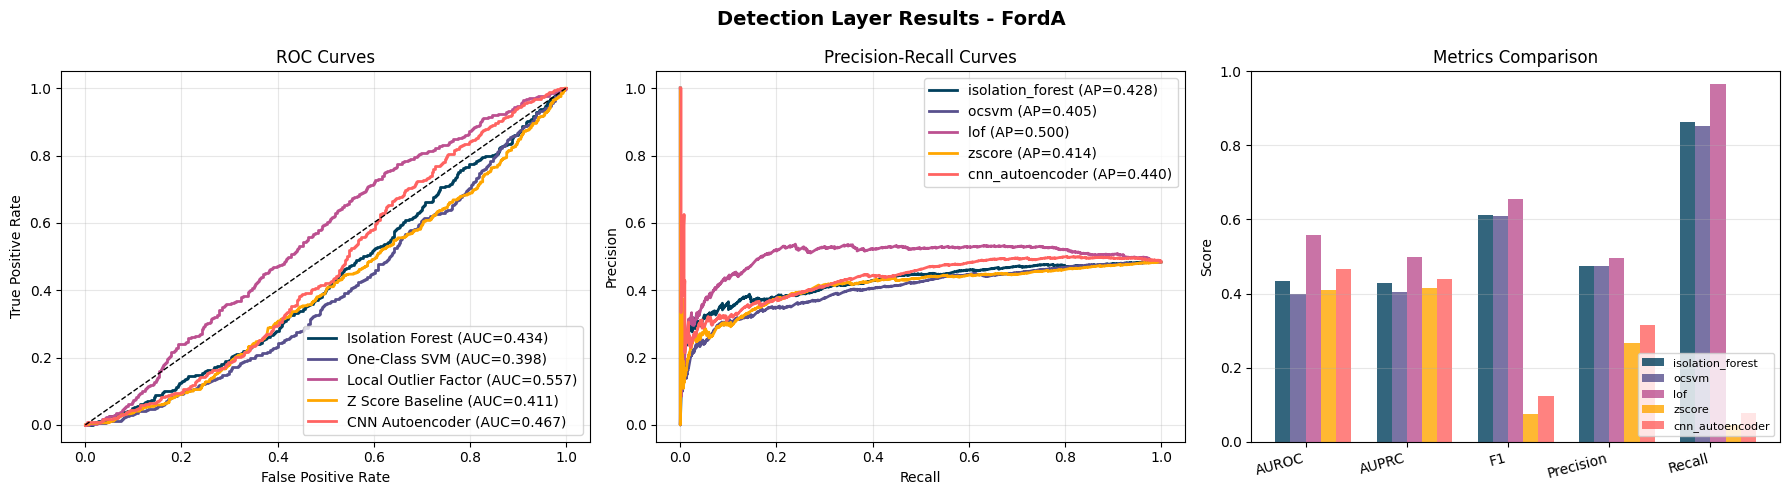

In [135]:
# ROC and PR Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = {'isolation_forest': '#003f5c', 'ocsvm': '#58508d', 'lof': '#bc5090', 'cnn_autoencoder': '#ff6361', 'zscore': '#ffa600'}

detector_scores = {
    'isolation_forest': detectors['isolation_forest'].decision_function(X_test_scaled),
    'ocsvm': detectors['ocsvm'].decision_function(X_test_scaled),
    'lof': detectors['lof'].decision_function(X_test_scaled),
    'zscore': detectors['zscore'].decision_function(X_test_scaled),
    'cnn_autoencoder': detectors['cnn_autoencoder'].decision_function(X_test)
}

# ROC Curves
for key, scores in detector_scores.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    axes[0].plot(fpr, tpr, label=f'{DETECTOR_NAMES[key]} (AUC={auc:.3f})', color=colors[key], linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# PR Curves
for name, scores in detector_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.3f})', color=colors[name], linewidth=2)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Metrics comparison bar chart
metrics_to_plot = ['AUROC', 'AUPRC', 'F1', 'Precision', 'Recall']
x = np.arange(len(metrics_to_plot))
width = 0.15 

for i, (name, metrics) in enumerate(all_metrics.items()):
    values = [metrics[m] for m in metrics_to_plot]
    axes[2].bar(x + i*width, values, width, label=name, color=colors[name], alpha=0.8)

axes[2].set_ylabel('Score')
axes[2].set_title('Metrics Comparison')
axes[2].set_xticks(x + width * 1.5)
axes[2].set_xticklabels(metrics_to_plot, rotation=15, ha='right')
axes[2].legend(loc='lower right', fontsize=8)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim(0, 1)

plt.suptitle('Detection Layer Results - FordA ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('detection_results.png', dpi=150, bbox_inches='tight')
plt.show()

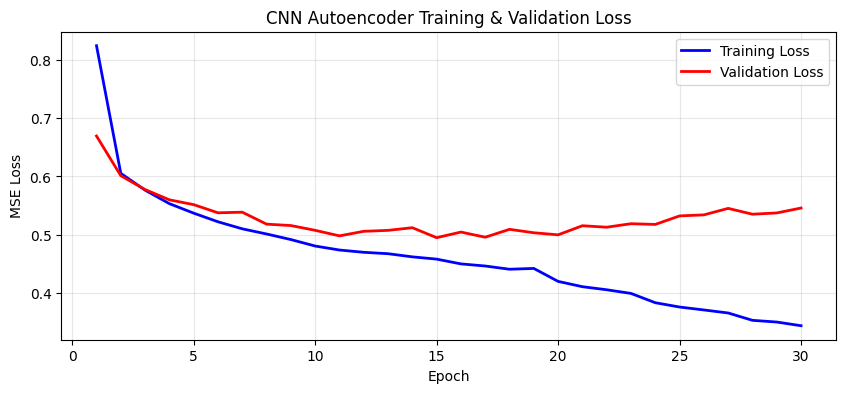

In [136]:
# CNN Autoencoder training curves
if hasattr(detectors['cnn_autoencoder'], 'training_losses'):
    fig, ax = plt.subplots(figsize=(10, 4))
    epochs = range(1, len(detectors['cnn_autoencoder'].training_losses) + 1)
    
    ax.plot(epochs, detectors['cnn_autoencoder'].training_losses, 'b-', linewidth=2, label='Training Loss')
    if hasattr(detectors['cnn_autoencoder'], 'validation_losses'):
        ax.plot(epochs, detectors['cnn_autoencoder'].validation_losses, 'r-', linewidth=2, label='Validation Loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title('CNN Autoencoder Training & Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.savefig('cnn_training_loss.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 6. Counterfactual Layer

Generate nearest-neighbour counterfactuals and evaluate quality metrics.

In [137]:
@dataclass
class CounterfactualResult:
    # Original
    original_idx: int
    original_signal: np.ndarray
    original_features: np.ndarray
    original_score: float
    
    # Counterfactual
    cf_idx: int
    cf_signal: np.ndarray
    cf_features: np.ndarray
    cf_score: float
    
    # Quality metrics
    validity: bool = False
    proximity: float = 0.0
    sparsity: int = 0
    
    # Feature differences
    feature_differences: Dict[str, Tuple[float, float, float]] = field(default_factory=dict)
    top_changes: List[Tuple[str, float, float, float]] = field(default_factory=list)

In [138]:
class NearestNeighbourCounterfactual:    
    def __init__(self, config: PipelineConfig, detector: AnomalyDetector,
                 feature_names: List[str], uses_features: bool = True):
        self.config = config
        self.detector = detector
        self.feature_names = feature_names
        self.uses_features = uses_features
        self.nn_model = None
        self.normal_signals = None
        self.normal_features = None
        self.normal_features_scaled = None
        
    
    def fit(self, X_signals: np.ndarray, X_features_scaled: np.ndarray, y: np.ndarray):
        normal_mask = (y == 0)
        self.normal_signals = X_signals[normal_mask]
        self.normal_features_scaled = X_features_scaled[normal_mask]
        
        self.nn_model = NearestNeighbors(
            n_neighbors=min(self.config.cf_search_k, len(self.normal_features_scaled)),
            metric=self.config.distance_metric
        )
        self.nn_model.fit(self.normal_features_scaled)
        print(f"  Counterfactual generator fitted on {len(self.normal_signals)} normal samples")
    
    def generate(self, idx: int, signal: np.ndarray, features_scaled: np.ndarray) -> CounterfactualResult:
        # Get original score
        if self.uses_features:
            original_score = self.detector.decision_function(features_scaled.reshape(1, -1))[0]
        else:
            original_score = self.detector.decision_function(signal[np.newaxis, ...])[0]
        
        # Find nearest normal neighbour
        distances, indices = self.nn_model.kneighbors(features_scaled.reshape(1, -1))
        cf_idx = indices[0, 0]
        
        cf_signal = self.normal_signals[cf_idx]
        cf_features_scaled = self.normal_features_scaled[cf_idx]
        
        # Get CF score
        if self.uses_features:
            cf_score = self.detector.decision_function(cf_features_scaled.reshape(1, -1))[0]
            cf_pred = self.detector.predict(cf_features_scaled.reshape(1, -1))[0]
        else:
            cf_score = self.detector.decision_function(cf_signal[np.newaxis, ...])[0]
            cf_pred = self.detector.predict(cf_signal[np.newaxis, ...])[0]
        
        # Calculate metrics
        validity = (cf_pred == 0)
        proximity = distances[0, 0]
        
        # Feature differences
        diffs = cf_features_scaled - features_scaled
        sparsity = int(np.sum(np.abs(diffs) > 0.5))
        
        # Top changes
        feature_diffs = {}
        for i, name in enumerate(self.feature_names):
            feature_diffs[name] = (features_scaled[i], cf_features_scaled[i], diffs[i])
        
        sorted_diffs = sorted(feature_diffs.items(), key=lambda x: abs(x[1][2]), reverse=True)
        top_changes = [(name, orig, cf, diff) for name, (orig, cf, diff) in sorted_diffs[:10]]
        
        return CounterfactualResult(
            original_idx=idx,
            original_signal=signal,
            original_features=features_scaled,
            original_score=original_score,
            cf_idx=cf_idx,
            cf_signal=cf_signal,
            cf_features=cf_features_scaled,
            cf_score=cf_score,
            validity=validity,
            proximity=proximity,
            sparsity=sparsity,
            feature_differences=feature_diffs,
            top_changes=top_changes
        )

In [139]:
# Select primary detector
primary_detector = detectors[config.primary_detector]
uses_features = config.primary_detector != 'cnn_autoencoder'

print(f"Primary detector: {DETECTOR_NAMES[config.primary_detector]}")
print(f"Uses features: {uses_features}")

# Initialize counterfactual generator
cf_generator = NearestNeighbourCounterfactual(
    config=config,
    detector=primary_detector,
    feature_names=feature_extractor.feature_names,
    uses_features=uses_features
)
cf_generator.fit(X_train, X_train_scaled, y_train)

Primary detector: Isolation Forest
Uses features: True
  Counterfactual generator fitted on 1846 normal samples


In [140]:
# Generate counterfactuals for all test anomalies
anomaly_indices = np.where(y_test == 1)[0]

counterfactuals = []
for idx in tqdm(anomaly_indices, desc="Generating CFs"):
    cf = cf_generator.generate(idx, X_test[idx], X_test_scaled[idx])
    counterfactuals.append(cf)


Generating CFs: 100%|██████████| 639/639 [00:18<00:00, 34.47it/s]


In [141]:
# Counterfactual Quality Summary
validity_rate = sum(cf.validity for cf in counterfactuals) / len(counterfactuals)
mean_proximity = np.mean([cf.proximity for cf in counterfactuals])
std_proximity = np.std([cf.proximity for cf in counterfactuals])
mean_sparsity = np.mean([cf.sparsity for cf in counterfactuals])
std_sparsity = np.std([cf.sparsity for cf in counterfactuals])

print("\n" + "="*70)
print("COUNTERFACTUAL QUALITY SUMMARY")
print("="*70)
print(f"  Validity Rate:  {validity_rate:.2%}")
print(f"  Proximity:      {mean_proximity:.4f} ± {std_proximity:.4f}")
print(f"  Sparsity:       {mean_sparsity:.1f} ± {std_sparsity:.1f} features")

cf_quality_df = pd.DataFrame({
    'Metric': ['Validity Rate', 'Mean Proximity', 'Mean Sparsity'],
    'Value': [f"{validity_rate:.2%}", f"{mean_proximity:.4f}", f"{mean_sparsity:.1f}"],
    'Std': ['-', f"± {std_proximity:.4f}", f"± {std_sparsity:.1f}"]
})
print("\n")
print(cf_quality_df.to_string(index=False))


COUNTERFACTUAL QUALITY SUMMARY
  Validity Rate:  22.38%
  Proximity:      2.7403 ± 0.6530
  Sparsity:       8.6 ± 3.5 features


        Metric  Value      Std
 Validity Rate 22.38%        -
Mean Proximity 2.7403 ± 0.6530
 Mean Sparsity    8.6    ± 3.5


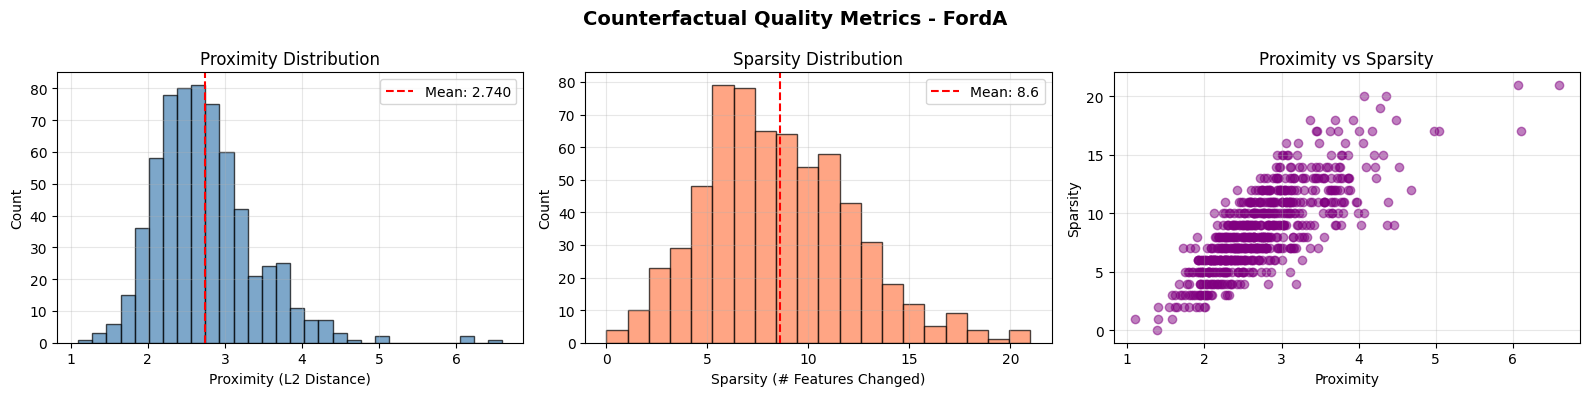

In [142]:
# Visualize counterfactual quality
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Proximity distribution
proximities = [cf.proximity for cf in counterfactuals]
axes[0].hist(proximities, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(mean_proximity, color='red', linestyle='--', label=f'Mean: {mean_proximity:.3f}')
axes[0].set_xlabel('Proximity (L2 Distance)')
axes[0].set_ylabel('Count')
axes[0].set_title('Proximity Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sparsity distribution
sparsities = [cf.sparsity for cf in counterfactuals]
axes[1].hist(sparsities, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(mean_sparsity, color='red', linestyle='--', label=f'Mean: {mean_sparsity:.1f}')
axes[1].set_xlabel('Sparsity (# Features Changed)')
axes[1].set_ylabel('Count')
axes[1].set_title('Sparsity Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Proximity vs Sparsity
axes[2].scatter(proximities, sparsities, alpha=0.5, color='purple')
axes[2].set_xlabel('Proximity')
axes[2].set_ylabel('Sparsity')
axes[2].set_title('Proximity vs Sparsity')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Counterfactual Quality Metrics - FordA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('counterfactual_quality.png', dpi=150, bbox_inches='tight')
plt.show()

In [143]:
def visualize_counterfactual(cf: CounterfactualResult, title: str = ""):
    fig = plt.figure(figsize=(16, 10))
    
    # Original + Counterfactual + Overlay
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.plot(cf.original_signal[:, 0], color='red', alpha=0.8, linewidth=1)
    ax1.set_title(f'Novel Sample (Score: {cf.original_score:.4f})')
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Normalized Brightness')
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(cf.cf_signal[:, 0], color='green', alpha=0.8, linewidth=1)
    ax2.set_title(f'Counterfactual (Score: {cf.cf_score:.4f})')
    ax2.set_xlabel('Timesteps')
    ax2.set_ylabel('Normalized Brightness')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.plot(cf.original_signal[:, 0], color='red', alpha=0.7, linewidth=1, label='Novel')
    ax3.plot(cf.cf_signal[:, 0], color='green', alpha=0.7, linewidth=1, label='Normal (CF)')
    ax3.set_title('Overlay Comparison')
    ax3.set_xlabel('Timesteps')
    ax3.set_ylabel('Normalized Brightness')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Top feature changes
    ax_feat = fig.add_subplot(2, 2, 3)
    top_n = min(8, len(cf.top_changes))
    names = [c[0][:15] for c in cf.top_changes[:top_n]] 
    orig_vals = [c[1] for c in cf.top_changes[:top_n]]
    cf_vals = [c[2] for c in cf.top_changes[:top_n]]
    
    x = np.arange(top_n)
    width = 0.35
    ax_feat.bar(x - width/2, orig_vals, width, label='Original (Novel)', color='red', alpha=0.7)
    ax_feat.bar(x + width/2, cf_vals, width, label='Counterfactual (Normal)', color='green', alpha=0.7)
    ax_feat.set_xticks(x)
    ax_feat.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax_feat.set_ylabel('Feature Value (scaled)')
    ax_feat.set_title('Top Feature Changes')
    ax_feat.legend(loc='upper right', fontsize=8)
    ax_feat.grid(True, alpha=0.3, axis='y')
    
    # Quality metrics text
    ax_text = fig.add_subplot(2, 2, 4)
    ax_text.axis('off')
    
    metrics_text = f"""
    COUNTERFACTUAL QUALITY
    {'='*35}
    
    Validity:   {'VALID' if cf.validity else 'INVALID'}
    Proximity:  {cf.proximity:.4f}
    Sparsity:   {cf.sparsity} features changed
    
    Anomaly Score:    {cf.original_score:.4f}
    Normal CF Score:  {cf.cf_score:.4f}
    
    TOP CHANGES:
    """
    for name, orig, cf_val, diff in cf.top_changes[:5]:
        direction = "↑" if diff > 0 else "↓"
        metrics_text += f"\n    • {name[:25]}: {direction} {abs(diff):.2f}"
    
    ax_text.text(0.05, 0.95, metrics_text, transform=ax_text.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle(title or 'Counterfactual Explanation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


Example Counterfactuals:


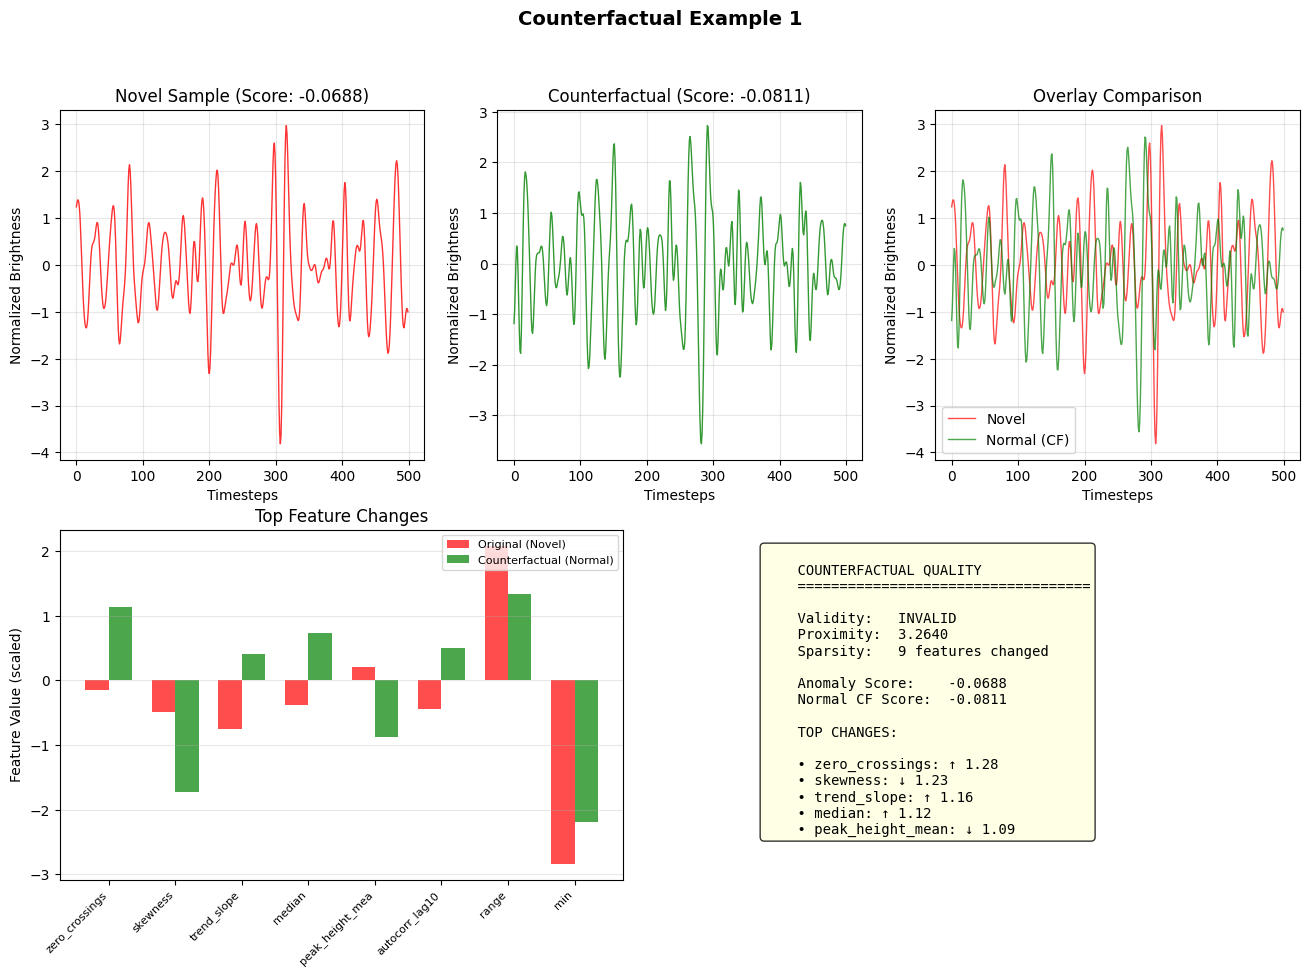

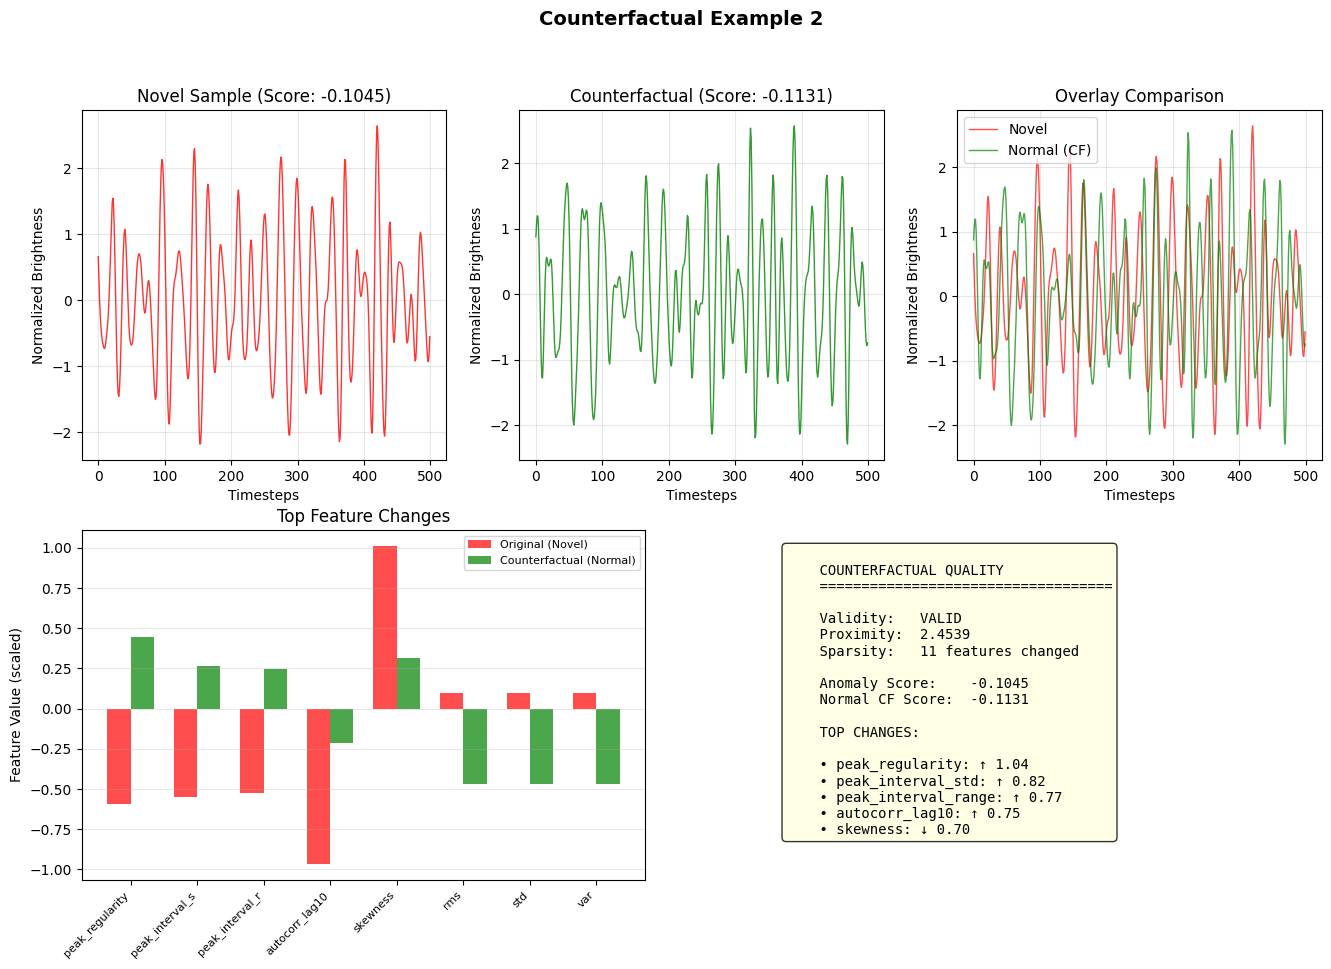

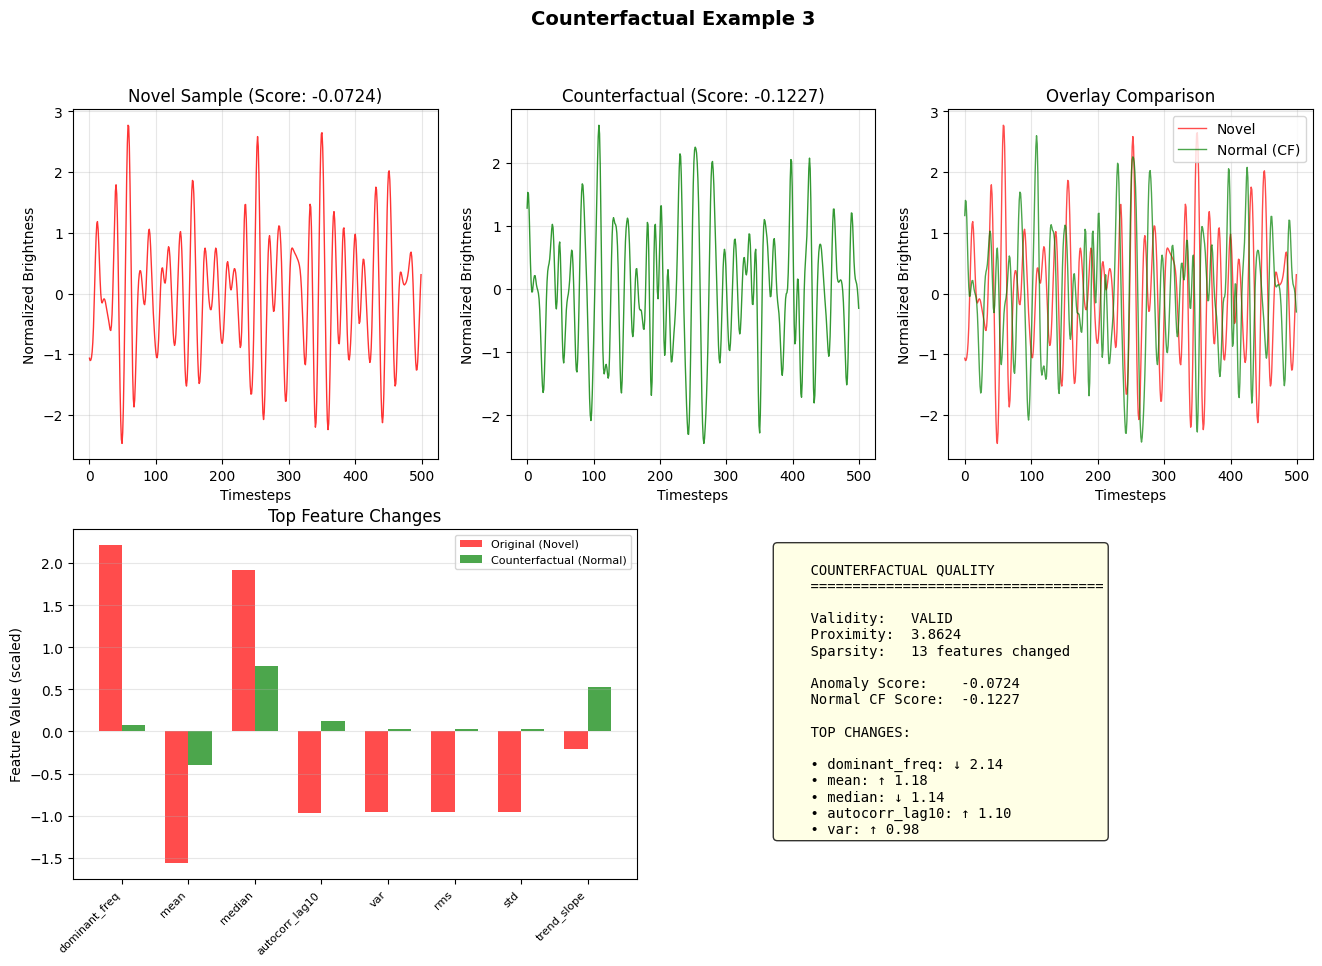

In [144]:
# Visualize example counterfactuals
print("\nExample Counterfactuals:")
for i in range(min(3, len(counterfactuals))):
    fig = visualize_counterfactual(counterfactuals[i], f"Counterfactual Example {i+1}")
    plt.savefig(f'cf_example_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 8. Summary & Export

In [ ]:
results_df.to_csv('detection_results.csv')

# Summary dict
summary = {
    'dataset': 'FordA Curves',
    'n_train': len(X_train),
    'n_test': len(X_test),
    'n_novel_test': int(sum(y_test)),
    'detection': all_metrics,
    'counterfactual': {
        'validity_rate': validity_rate,
        'mean_proximity': float(mean_proximity),
        'mean_sparsity': float(mean_sparsity)
    }
}

with open('pipeline_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nResults exported:")
print("  - detection_results.csv")
print("  - pipeline_summary.json")
print("  - detection_results.png")
print("  - counterfactual_quality.png")
print("  - cf_example_*.png")


Results exported:
  - detection_results.csv
  - pipeline_summary.json
  - detection_results.png
  - counterfactual_quality.png
  - cf_example_*.png
